In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn import metrics

In [2]:
train = pd.read_csv(r'hr_temp_20170201-20200131_subset.csv', parse_dates = ['DATE'])
temp_eval = pd.read_csv(r'hr_temp_20200201-20200229_subset.csv', parse_dates = ['DATE'])
hrl = pd.read_csv(r'hrl_load_metered - 20170201-20200131.csv', parse_dates = ['datetime_beginning_utc','datetime_beginning_ept'])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   STATION                   26280 non-null  int64         
 1   DATE                      26280 non-null  datetime64[ns]
 2   REPORT_TYPE               26280 non-null  object        
 3   SOURCE                    26280 non-null  int64         
 4   HourlyDryBulbTemperature  26243 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.0+ MB


In [4]:
hrl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   datetime_beginning_utc  26280 non-null  datetime64[ns]
 1   datetime_beginning_ept  26280 non-null  datetime64[ns]
 2   nerc_region             26280 non-null  object        
 3   mkt_region              26280 non-null  object        
 4   zone                    26280 non-null  object        
 5   load_area               26280 non-null  object        
 6   mw                      26280 non-null  float64       
 7   is_verified             26280 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(1), object(4)
memory usage: 1.4+ MB


In [5]:
train['DATE'] = train['DATE'].dt.floor('h')

In [6]:
hrl['DATE'] = hrl['datetime_beginning_utc'] + timedelta(hours = -5)

In [7]:
hrl.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified,DATE
0,2017-02-01 05:00:00,2017-02-01 00:00:00,RFC,WEST,DUQ,DUQ,1419.881,True,2017-02-01 00:00:00
1,2017-02-01 06:00:00,2017-02-01 01:00:00,RFC,WEST,DUQ,DUQ,1379.505,True,2017-02-01 01:00:00
2,2017-02-01 07:00:00,2017-02-01 02:00:00,RFC,WEST,DUQ,DUQ,1366.106,True,2017-02-01 02:00:00
3,2017-02-01 08:00:00,2017-02-01 03:00:00,RFC,WEST,DUQ,DUQ,1364.453,True,2017-02-01 03:00:00
4,2017-02-01 09:00:00,2017-02-01 04:00:00,RFC,WEST,DUQ,DUQ,1391.265,True,2017-02-01 04:00:00


In [8]:
train.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01 00:00:00,FM-15,7,37.0
1,72520514762,2017-02-01 01:00:00,FM-15,7,37.0
2,72520514762,2017-02-01 02:00:00,FM-15,7,36.0
3,72520514762,2017-02-01 03:00:00,FM-15,7,36.0
4,72520514762,2017-02-01 04:00:00,FM-15,7,36.0


In [9]:
train = pd.merge(train, hrl, how = 'left')

In [10]:
drop_cols = train.columns.tolist()
drop_cols.remove('mw')
drop_cols.remove('HourlyDryBulbTemperature')
drop_cols.remove('DATE')
train = train.drop(columns = drop_cols)
train.head()

,DATE,HourlyDryBulbTemperature,mw
0,2017-02-01 00:00:00,37.0,1419.881
1,2017-02-01 01:00:00,37.0,1379.505
2,2017-02-01 02:00:00,36.0,1366.106
3,2017-02-01 03:00:00,36.0,1364.453
4,2017-02-01 04:00:00,36.0,1391.265


In [11]:
train['hour'] = train['DATE'].dt.hour
train['weekday'] = train['DATE'].dt.dayofweek
train['month'] = train['DATE'].dt.month
train['year'] = train['DATE'].dt.year
train.columns = train.columns.str.lower()
train = train.set_index('date')

In [12]:
train = train.rename(columns = {'hourlydrybulbtemperature':'temp'})
train = train.reindex(columns = ['mw','temp','hour','weekday','month','year'])

In [13]:
train.head(30)

,mw,temp,hour,weekday,month,year
date,,,,,,
2017-02-01 00:00:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:00:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:00:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:00:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:00:00,1391.265,36.0,4,2,2,2017
2017-02-01 05:00:00,1477.343,36.0,5,2,2,2017
2017-02-01 06:00:00,1585.252,34.0,6,2,2,2017
2017-02-01 07:00:00,1671.412,33.0,7,2,2,2017
2017-02-01 08:00:00,1708.597,34.0,8,2,2,2017


In [14]:
train = train.interpolate()

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-02-01 00:00:00 to 2020-01-31 23:00:00
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mw       26280 non-null  float64
 1   temp     26280 non-null  float64
 2   hour     26280 non-null  int64  
 3   weekday  26280 non-null  int64  
 4   month    26280 non-null  int64  
 5   year     26280 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 1.4 MB


In [16]:
test = train[train['year'] == 2020]
train = train[train['year'] < 2020]

Text(0.5, 1.0, 'Temperature Over Time')

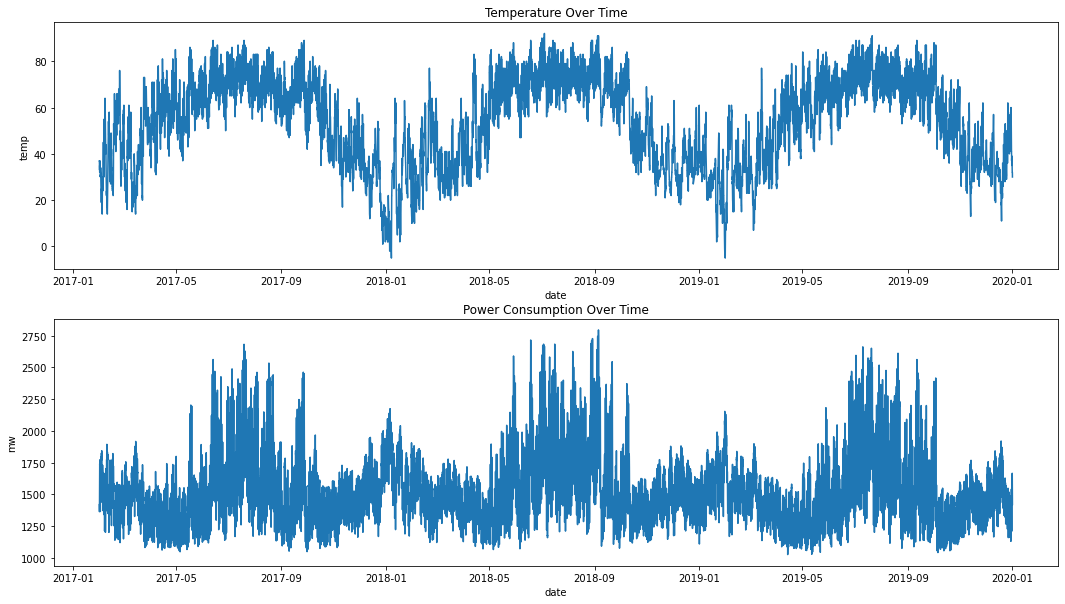

In [17]:
fig, axes = plt.subplots(2, 1, figsize = (18,10))
g1 = sns.lineplot(ax = axes[1], data = train.mw)
g2 = sns.lineplot(ax = axes[0], data = train.temp)
g1.set_title('Power Consumption Over Time')
g2.set_title('Temperature Over Time')

Text(0.5, 1.0, 'Power Consumption Over One Week (2/13/17 to 2/20/17)')

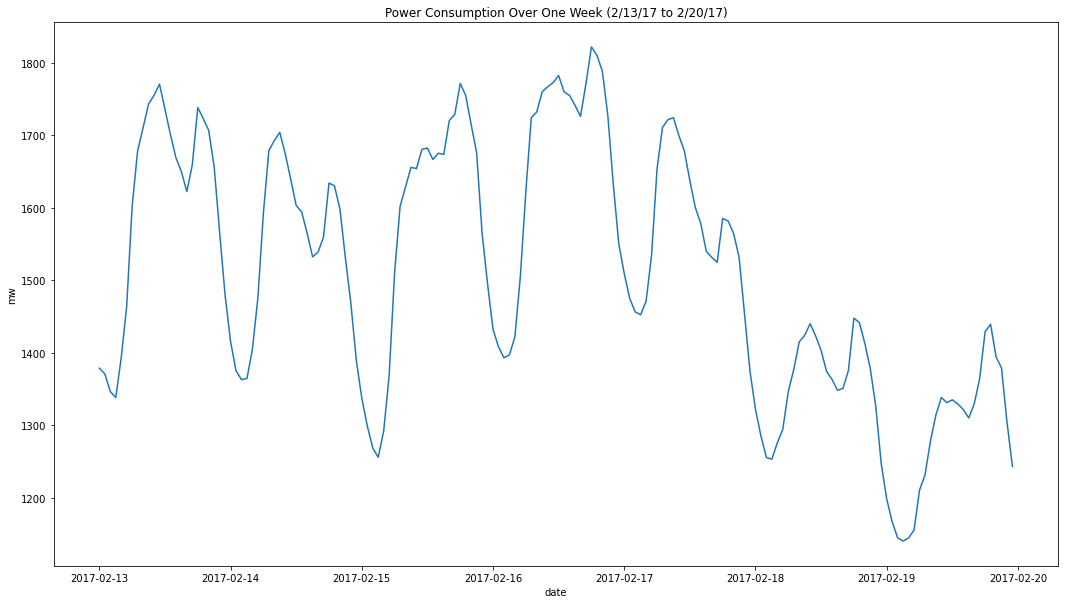

In [18]:
fig, axes = plt.subplots(figsize = (18,10))
g1 = sns.lineplot(data = train.mw[(train.index >= '2017-02-13') & (train.index < '2017-02-20')])
g1.set_title('Power Consumption Over One Week (2/13/17 to 2/20/17)')

In [19]:
correlation = train.corr()
correlation['mw']['temp']

0.3275395569074099

Text(0, 0.5, 'Megawatt Hours')

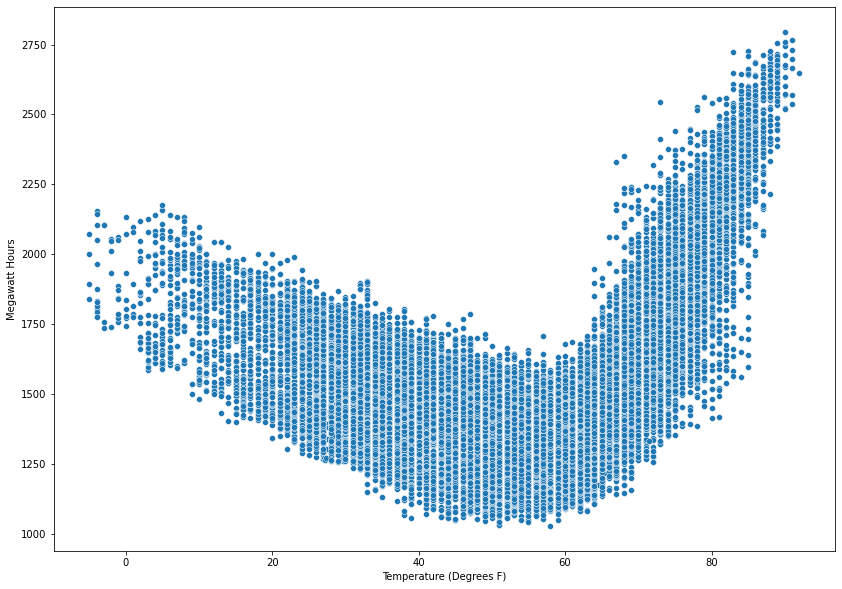

In [20]:
fig, ax = plt.subplots(figsize = (14, 10))
p = sns.scatterplot(x = train.temp, y = train.mw)
p.set_xlabel('Temperature (Degrees F)')
p.set_ylabel('Megawatt Hours')

In [21]:
scaler = StandardScaler()
train[['mw', 'temp']] = scaler.fit_transform(train[['mw', 'temp']])

In [23]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
mw,25536.0,8.882089e-17,1.000020,-1.859451,-0.680554,-0.156294,0.470613,4.307488
temp,25536.0,-3.182778e-15,1.000020,-3.097367,-0.818520,0.135416,0.824370,2.043288
hour,25536.0,1.150000e+01,6.922322,0.000000,5.750000,11.500000,17.250000,23.000000
weekday,25536.0,3.000000e+00,2.000039,0.000000,1.000000,3.000000,5.000000,6.000000
month,25536.0,6.687030e+00,3.364349,1.000000,4.000000,7.000000,10.000000,12.000000
year,25536.0,2.018029e+03,0.810020,2017.000000,2017.000000,2018.000000,2019.000000,2019.000000


In [24]:
train['temp2'] = train['temp']**2
test['temp2'] = test['temp']**2
train.head()

,mw,temp,hour,weekday,month,year,temp2
date,,,,,,,
2017-02-01 00:00:00,-0.489462,-0.871516,0,2,2,2017,0.759540
2017-02-01 01:00:00,-0.630299,-0.871516,1,2,2,2017,0.759540
2017-02-01 02:00:00,-0.677037,-0.924513,2,2,2,2017,0.854723
2017-02-01 03:00:00,-0.682803,-0.924513,3,2,2,2017,0.854723
2017-02-01 04:00:00,-0.589279,-0.924513,4,2,2,2017,0.854723


In [25]:
y_train = train.mw
x_train = train.drop(columns = ['mw'])

In [26]:
model = smf.ols(formula = 'mw ~ temp2 + C(weekday) + C(hour) + C(month)', data = train).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     mw   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     2373.
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:58:47   Log-Likelihood:                -16161.
No. Observations:               25536   AIC:                         3.241e+04
Df Residuals:                   25494   BIC:                         3.275e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.4992      0.021    -72.980      0.000      -1.539      -1.459
C(weekday)[T.1]     0.0392      0.011      3.666      0.000       0.018       0.060
C(weekday)[T.2]     0.0786      0.011      7.354      0.000       0.058       0.100
C(weekday)[T.3]     0.0659      0.011      6.169      0.000       0.045       0.087
C(weekday)[T.4]    -0.0083      0.011     -0.774      0.439      -0.029       0.013
C(weekday)[T.5]    -0.3743      0.011    -35.039      0.000      -0.395      -0.353
C(weekday)[T.6]    -0.4105      0.011    -38.438      0.000      -0.431      -0.390
C(hour)[T.1]       -0.1215      0.020     -6.148      0.000      -0.160      -0.083
C(hour)[T.2]       -0.1854      0.020     -9.379      0.000      -0.224      -0.147
C(hour)[T.3]       -0.1712      0.020     -8.657      0.000      -0.210      -0.132
C(hour)[T.4]       -0.0371      0.020     -1.878      0.060      -0.076       0.002
C(hour)[T.5]        0.1947      0.020      9.850      0.000       0.156       0.233
C(hour)[T.6]        0.4443      0.020     22.469      0.000       0.405       0.483
C(hour)[T.7]        0.6573      0.020     33.239      0.000       0.619       0.696
C(hour)[T.8]        0.8305      0.020     41.997      0.000       0.792       0.869
C(hour)[T.9]        0.9757      0.020     49.334      0.000       0.937       1.015
C(hour)[T.10]       1.0780      0.020     54.494      0.000       1.039       1.117
C(hour)[T.11]       1.1481      0.020     58.027      0.000       1.109       1.187
C(hour)[T.12]       1.1970      0.020     60.487      0.000       1.158       1.236
C(hour)[T.13]       1.2188      0.020     61.579      0.000       1.180       1.258
C(hour)[T.14]       1.2218      0.020     61.727      0.000       1.183       1.261
C(hour)[T.15]       1.2412      0.020     62.719      0.000       1.202       1.280
C(hour)[T.16]       1.2653      0.020     63.945      0.000       1.226       1.304
C(hour)[T.17]       1.2940      0.020     65.413      0.000       1.255       1.333
C(hour)[T.18]       1.2828      0.020     64.866      0.000       1.244       1.322
C(hour)[T.19]       1.2345      0.020     62.435      0.000       1.196       1.273
C(hour)[T.20]       1.0954      0.020     55.403      0.000       1.057       1.134
C(hour)[T.21]       0.8142      0.020     41.182      0.000       0.775       0.853
C(hour)[T.22]       0.4816      0.020     24.360      0.000       0.443       0.520
C(hour)[T.23]       0.1932      0.020      9.772      0.000       0.154       0.232
C(month)[T.2]       0.2097      0.016     13.042      0.000       0.178       0.241
C(month)[T.3]       0.0927      0.016      5.872      0.000       0.062       0.124
C(month)[T.4]      -0.0108      0.017     -0.652      0.514      -0.043       0.022
C(month)[T.5]       0.2803      0.016     17.222      0.000

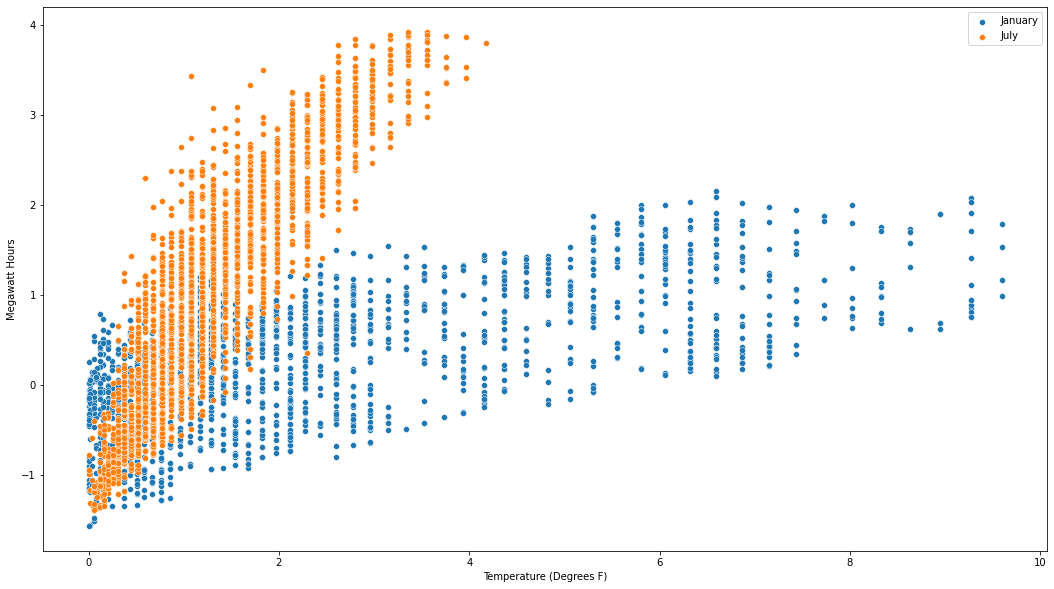

In [28]:
fig, ax = plt.subplots(figsize = (18, 10))
p1 = sns.scatterplot(x = train[train.month == 1].temp2, y = train[train.month == 1].mw)
p1.set_xlabel('Temperature (Degrees F)')
p1.set_ylabel('Megawatt Hours')
p2 = sns.scatterplot(x = train[train.month == 7].temp2, y = train[train.month == 7].mw)
plt.legend(labels = ['January','July'])

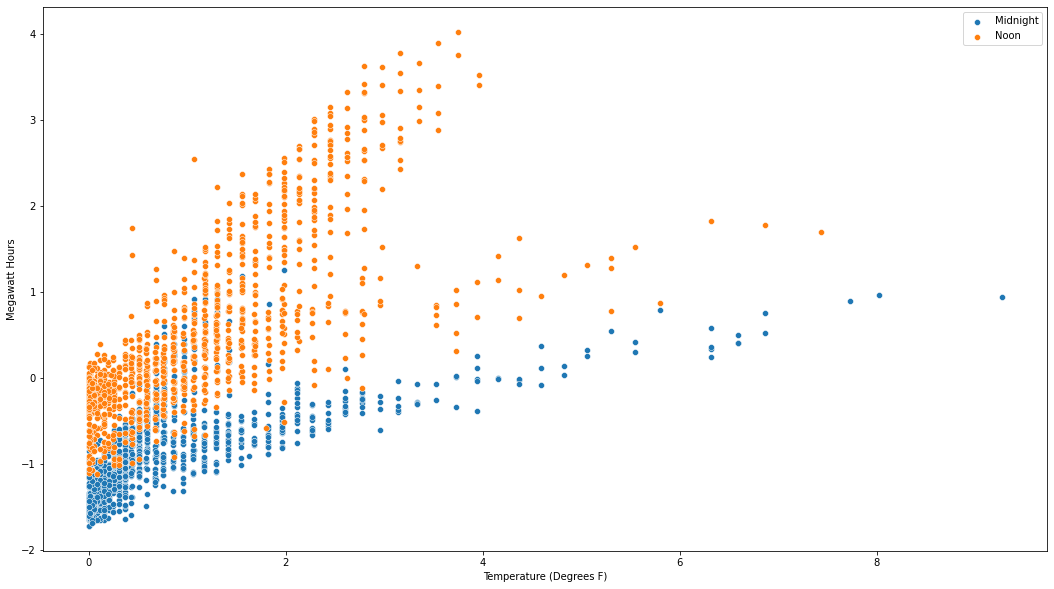

In [29]:
fig, ax = plt.subplots(figsize = (18, 10))
p1 = sns.scatterplot(x = train[train.hour == 0].temp2, y = train[train.hour == 0].mw)
p1.set_xlabel('Temperature (Degrees F)')
p1.set_ylabel('Megawatt Hours')
p2 = sns.scatterplot(x = train[train.hour == 12].temp2, y = train[train.hour == 12].mw)
plt.legend(labels = ['Midnight','Noon'])

In [30]:
model2 = smf.ols(formula = 'mw ~ temp2 + C(weekday) + C(hour) + C(month) + temp2*C(weekday) + temp2*C(month)', data = train).fit()

In [31]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     mw   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     4021.
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:59:06   Log-Likelihood:                -6640.8
No. Observations:               25536   AIC:                         1.340e+04
Df Residuals:                   25477   BIC:                         1.388e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.7892      0.017    -47.086      0.000      -0.822      -0.756
C(weekday)[T.1]           0.0033      0.010      0.329      0.742      -0.016       0.023
C(weekday)[T.2]           0.0694      0.010      7.065      0.000       0.050       0.089
C(weekday)[T.3]           0.0684      0.010      6.919      0.000       0.049       0.088
C(weekday)[T.4]           0.0012      0.010      0.119      0.905      -0.018       0.021
C(weekday)[T.5]          -0.3538      0.010    -35.667      0.000      -0.373      -0.334
C(weekday)[T.6]          -0.4148      0.010    -42.166      0.000      -0.434      -0.396
C(hour)[T.1]             -0.1056      0.014     -7.750      0.000      -0.132      -0.079
C(hour)[T.2]             -0.1537      0.014    -11.281      0.000      -0.180      -0.127
C(hour)[T.3]             -0.1269      0.014     -9.314      0.000      -0.154      -0.100
C(hour)[T.4]              0.0151      0.014      1.106      0.269      -0.012       0.042
C(hour)[T.5]              0.2491      0.014     18.279      0.000       0.222       0.276
C(hour)[T.6]              0.4794      0.014     35.180      0.000       0.453       0.506
C(hour)[T.7]              0.6481      0.014     47.570      0.000       0.621       0.675
C(hour)[T.8]              0.7534      0.014     55.255      0.000       0.727       0.780
C(hour)[T.9]              0.8169      0.014     59.781      0.000       0.790       0.844
C(hour)[T.10]             0.8425      0.014     61.447      0.000       0.816       0.869
C(hour)[T.11]             0.8528      0.014     61.982      0.000       0.826       0.880
C(hour)[T.12]             0.8529      0.014     61.788      0.000       0.826       0.880
C(hour)[T.13]             0.8502      0.014     61.478      0.000       0.823       0.877
C(hour)[T.14]             0.8445      0.014     61.019      0.000       0.817       0.872
C(hour)[T.15]             0.8792      0.014     63.607      0.000       0.852       0.906
C(hour)[T.16]             0.9401      0.014     68.201      0.000       0.913       0.967
C(hour)[T.17]             1.0220      0.014     74.391      0.000       0.995       1.049
C(hour)[T.18]             1.0749      0.014     78.517      0.000       1.048       1.102
C(hour)[T.19]             1.0886      0.014     79.717      0.000       1.062       1.115
C(hour)[T.20]             0.9887      0.014     72.477      0.000       0.962       1.015
C(hour)[T.21]             0.7416      0.014     54.401      0.000       0.715       0.768
C(hour)[T.22]             0.4378      0.014     32.128      0.000       0.411       0.464
C(hour)[T.23]             0.1737      0.014     12.747      0.000       0.147       0.200
C(month)[T.2]            -0.1723      0.016    -10.994      0.000      -0.203      -0.142
C(month)[T.3]          

In [32]:
model3 = smf.ols(formula = 'mw ~ temp2 + C(weekday) + C(hour) + C(month) + temp2*C(weekday) + temp2*C(month) + C(hour)*C(weekday)', data = train).fit()

In [33]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     mw   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     1357.
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:59:12   Log-Likelihood:                -5049.8
No. Observations:               25536   AIC:                         1.049e+04
Df Residuals:                   25339   BIC:                         1.210e+04
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.9147      0.027    -34.083      0.000      -0.967      -0.862
C(weekday)[T.1]                  -0.0083      0.034     -0.240      0.810      -0.076       0.059
C(weekday)[T.2]                   0.0961      0.034      2.795      0.005       0.029       0.163
C(weekday)[T.3]                   0.1092      0.034      3.175      0.002       0.042       0.177
C(weekday)[T.4]                   0.0909      0.034      2.642      0.008       0.023       0.158
C(weekday)[T.5]                   0.0254      0.034      0.737      0.461      -0.042       0.093
C(weekday)[T.6]                  -0.0639      0.034     -1.859      0.063      -0.131       0.003
C(hour)[T.1]                     -0.0945      0.034     -2.784      0.005      -0.161      -0.028
C(hour)[T.2]                     -0.1168      0.034     -3.440      0.001      -0.183      -0.050
C(hour)[T.3]                     -0.0670      0.034     -1.972      0.049      -0.134      -0.000
C(hour)[T.4]                      0.1099      0.034      3.237      0.001       0.043       0.176
C(hour)[T.5]                      0.4061      0.034     11.958      0.000       0.340       0.473
C(hour)[T.6]                      0.6737      0.034     19.837      0.000       0.607       0.740
C(hour)[T.7]                      0.8439      0.034     24.847      0.000       0.777       0.910
C(hour)[T.8]                      0.9429      0.034     27.759      0.000       0.876       1.010
C(hour)[T.9]                      1.0012      0.034     29.460      0.000       0.935       1.068
C(hour)[T.10]                     1.0277      0.034     30.223      0.000       0.961       1.094
C(hour)[T.11]                     1.0411      0.034     30.600      0.000       0.974       1.108
C(hour)[T.12]                     1.0665      0.034     31.336      0.000       1.000       1.133
C(hour)[T.13]                     1.0326      0.034     30.323      0.000       0.966       1.099
C(hour)[T.14]                     1.0268      0.034     30.147      0.000       0.960       1.094
C(hour)[T.15]                     1.0426      0.034     30.616      0.000       0.976       1.109
C(hour)[T.16]                     1.0947      0.034     32.162      0.000       1.028       1.161
C(hour)[T.17]                     1.1787      0.034     34.654      0.000       1.112       1.245
C(hour)[T.18]                     1.2329      0.034     36.276      0.000       1.166       1.300
C(hour)[T.19]                     1.2282      0.034     36.154      0.000       1.162       1.295
C(hour)[T.20]                     1.1053      0.034     32.542      0.000       1.039       1.172
C(hour)[T.21]                     0.8301      0.034     24.441      0.000       0.763       0.897
C(hour)[T.22]                     0.4863     

In [60]:
metrics.mean_absolute_percentage_error(train.mw, model3.predict(train))

1.849915769242865

In [36]:
test.head()

,mw,temp,hour,weekday,month,year,temp2
date,,,,,,,
2020-01-01 00:00:00,1363.428,31.0,0,2,1,2020,961.0
2020-01-01 01:00:00,1335.975,29.0,1,2,1,2020,841.0
2020-01-01 02:00:00,1296.817,30.0,2,2,1,2020,900.0
2020-01-01 03:00:00,1288.403,30.0,3,2,1,2020,900.0
2020-01-01 04:00:00,1292.263,31.0,4,2,1,2020,961.0


In [37]:
test[['mw', 'temp']] = scaler.transform(test[['mw', 'temp']])

In [38]:
test['temp2'] = test['temp']**2

In [39]:
jan_pred = model3.predict(test)

In [40]:
jan_pred.head()

date
2020-01-01 00:00:00   -0.517755
2020-01-01 01:00:00   -0.582743
2020-01-01 02:00:00   -0.632850
2020-01-01 03:00:00   -0.593334
2020-01-01 04:00:00   -0.435494
dtype: float64

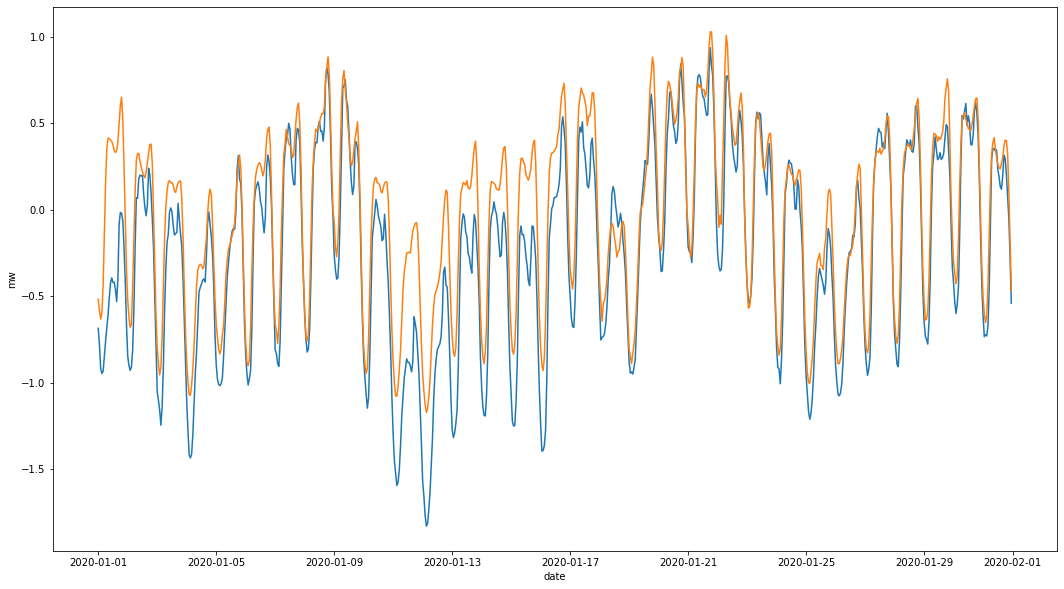

In [41]:
fig, axes = plt.subplots(figsize = (18,10))
g1 = sns.lineplot(data = test.mw)
g2 = sns.lineplot(data = jan_pred)

In [42]:
train['residual'] = train['mw'] - model3.predict(train)

In [43]:
test['residual'] = test['mw'] - model3.predict(test)

<AxesSubplot:xlabel='date', ylabel='residual'>

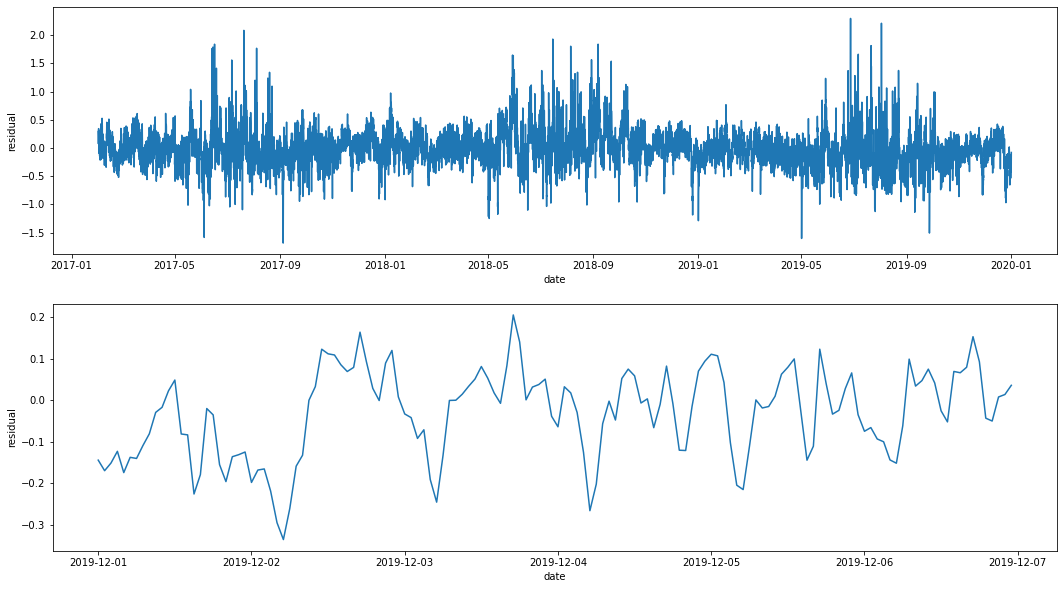

In [44]:
fig, axes = plt.subplots(2,1, figsize = (18, 10))
sns.lineplot(ax = axes[0], data = train.residual)
sns.lineplot(ax = axes[1], data = train.residual[(train.year == 2019) & (train.month == 12) & (train.index < '2019-12-07')])

In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [46]:
model4 = ExponentialSmoothing(train.residual, trend = None, seasonal ='add', seasonal_periods=24).fit()
exp_smooth = model4.forecast(744)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [47]:
jan_pred2 = jan_pred + exp_smooth

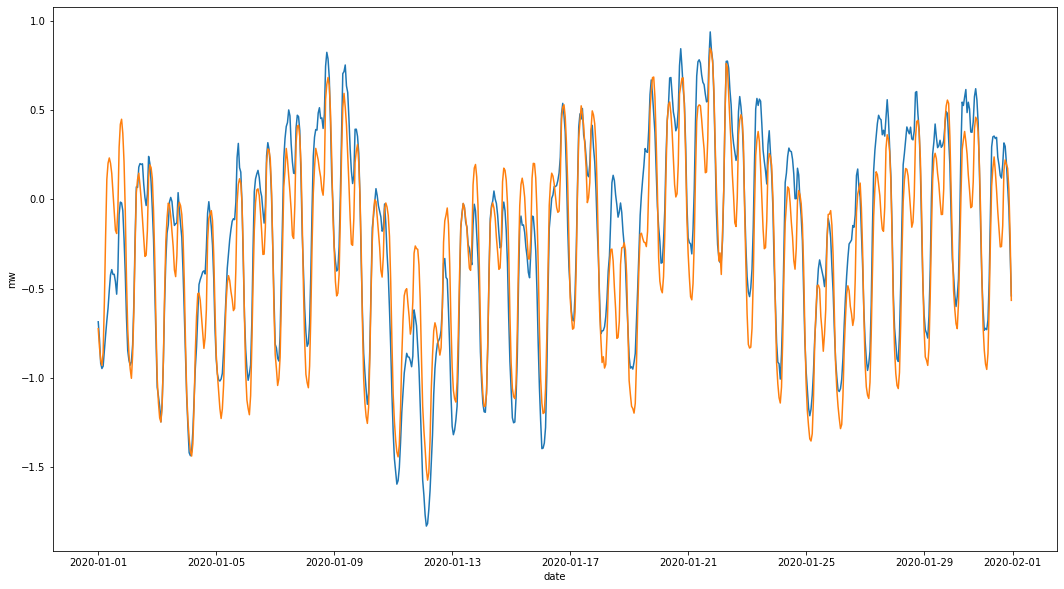

In [48]:
fig, axes = plt.subplots(figsize = (18,10))
g1 = sns.lineplot(data = test.mw)
g2 = sns.lineplot(data = jan_pred2)

In [79]:
model3.predict(train)

date
2017-02-01 00:00:00   -0.782478
2017-02-01 01:00:00   -0.903486
2017-02-01 02:00:00   -0.899236
2017-02-01 03:00:00   -0.859720
2017-02-01 04:00:00   -0.674467
                         ...   
2019-12-31 19:00:00    0.530793
2019-12-31 20:00:00    0.413676
2019-12-31 21:00:00    0.157794
2019-12-31 22:00:00   -0.116385
2019-12-31 23:00:00   -0.403483
Length: 25536, dtype: float64

In [78]:
model4.predict(train.index[0])

2017-02-01 00:00:00    0.293552
2017-02-01 01:00:00    0.258186
2017-02-01 02:00:00    0.235795
2017-02-01 03:00:00    0.180585
2017-02-01 04:00:00    0.098302
                         ...   
2019-12-31 19:00:00   -0.254841
2019-12-31 20:00:00   -0.307639
2019-12-31 21:00:00   -0.286591
2019-12-31 22:00:00   -0.280756
2019-12-31 23:00:00   -0.276769
Freq: H, Length: 25536, dtype: float64

In [80]:
metrics.mean_absolute_percentage_error(train.mw, model4.predict(train.index[0]) + model3.predict(train))

0.6718191881172633

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [55]:
model5 = SARIMAX(train.residual, order = (2,0,0), seasonal_order=(0,1,1,24)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [57]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             residual   No. Observations:                25536
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood               17166.811
Date:                              Thu, 21 Apr 2022   AIC                         -34325.623
Time:                                      16:25:07   BIC                         -34293.035
Sample:                                  02-01-2017   HQIC                        -34315.085
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8290      0.003    287.439      0.000       0.823       0.835
ar.L2          0.0687      0.003     21.799      0.000       0.063       0.075
ma.S.L24      -0.9231      0.002   -517.962      0.000      -0.927      -0.920
sigma2         0.0152   3.39e-05    448.902      0.000       0.015       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            958637.21
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             2.34
Prob(H) (two-sided):                  0.91   Kurtosis:                        32.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
metrics.mean_absolute_percentage_error(train.mw, model5.predict(train.index[0]) + model3.predict(train))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


0.4974868795217884

In [89]:
jan_pred3 = jan_pred + model5.predict(start = test.index[0], end = test.index[-1])

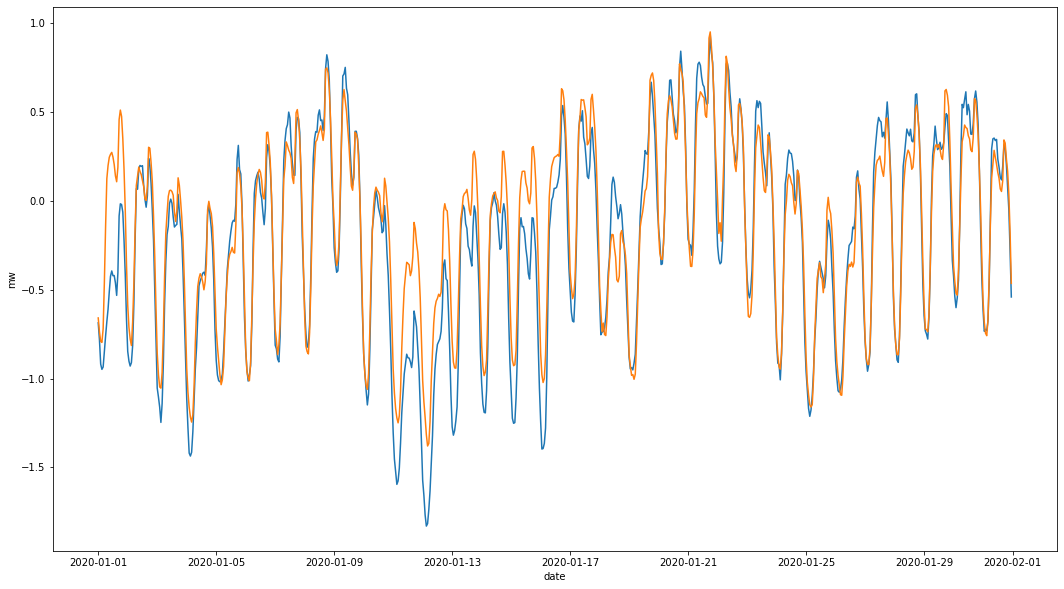

In [90]:
fig, axes = plt.subplots(figsize = (18,10))
g1 = sns.lineplot(data = test.mw)
g2 = sns.lineplot(data = jan_pred3)

In [95]:
metrics.mean_absolute_percentage_error(train.mw, (model5.predict(train.index[0]) + model4.predict(train.index[0]))/2 + model3.predict(train))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


0.5550879187063882

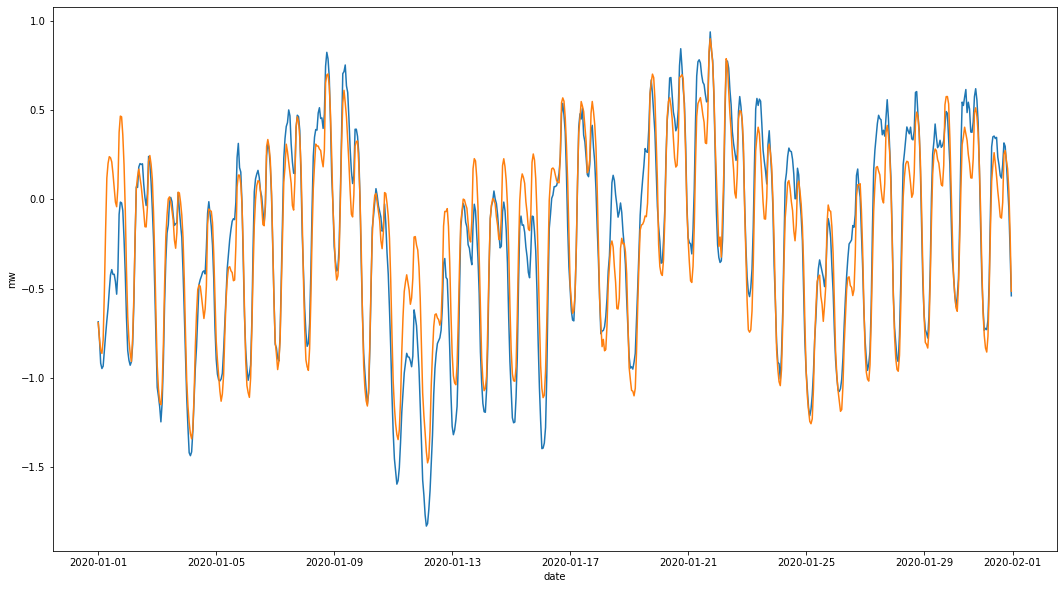

In [96]:
fig, axes = plt.subplots(figsize = (18,10))
g1 = sns.lineplot(data = test.mw)
g2 = sns.lineplot(data = (jan_pred3 + jan_pred2)/2)